<a href="https://colab.research.google.com/github/wmerry25/CS552-HW2/blob/main/DS552_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


#Pull data from Kaggle
path = kagglehub.dataset_download("parulpandey/palmer-archipelago-antarctica-penguin-data")

Using Colab cache for faster access to the 'palmer-archipelago-antarctica-penguin-data' dataset.


In [40]:
#Data Loading
penguins = '/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv'
dataIn = pd.read_csv(penguins)
filteredData = dataIn[dataIn['species'] != 'Chinstrap'].dropna()

#Class Labels
filteredData['species_label'] = filteredData['species'].astype('category').cat.codes
filteredData['sex_label'] = filteredData['sex'].astype('category').cat.codes
filteredData['island_label'] = filteredData['island'].astype('category').cat.codes

#Test Train Split
x = filteredData[['island_label','culmen_length_mm', 'culmen_depth_mm','flipper_length_mm', 'body_mass_g', 'sex_label']]
y = filteredData['species_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=3)

In [41]:
#Bayes
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred_NBTest = nb.predict(x_test)
y_pred_NBTrain = nb.predict(x_train)
y_prob_NBTest = nb.predict_proba(x_test)[:,1]

#Regression
lr = LogisticRegression(max_iter=300)
lr.fit(x_train,y_train)
y_pred_LRTest= lr.predict(x_test)
y_pred_LRTrain = lr.predict(x_train)
y_prob_LRTest = lr.predict_proba(x_test)[:,1]


In [42]:
#Accuracy
NB_train_accuracy = accuracy_score(y_train,y_pred_NBTrain)
NB_test_accuracy = accuracy_score(y_test,y_pred_NBTest)
LR_test_accuracy = lr.score(x_test,y_test)
LR_train_accuracy = lr.score(x_train, y_train)
print("*************** Accuracy ***************")
print(f"Naive Bayes Train Accuracy: {NB_train_accuracy}")
print(f"Naive Bayes Test Accuracy: {NB_test_accuracy}")
print(f"Logistic Regression Train Accuracy: {LR_train_accuracy}")
print(f"Logistic Regression Test Accuracy: {LR_test_accuracy}")
print()


*************** Accuracy ***************
Naive Bayes Train Accuracy: 0.9528301886792453
Naive Bayes Test Accuracy: 0.9259259259259259
Logistic Regression Train Accuracy: 1.0
Logistic Regression Test Accuracy: 1.0



In [43]:
#AUC
NB_train_auc = roc_auc_score(y_train,y_pred_NBTrain)
NB_test_auc = roc_auc_score(y_test,y_pred_NBTest)
LR_test_auc = roc_auc_score(y_test,y_pred_LRTest)
LR_train_auc = roc_auc_score(y_train,y_pred_LRTrain)
print("******* Area Under The ROC Curve *******")
print(f"Naive Bayes Train AUC: {NB_train_auc}")
print(f"Naive Bayes Test AUC: {NB_test_auc}")
print(f"Logistic Regression Train AUC: {LR_train_auc}")
print(f"Logistic Regression Test AUC: {LR_test_auc}")

******* Area Under The ROC Curve *******
Naive Bayes Train AUC: 0.9538750335210513
Naive Bayes Test AUC: 0.9307359307359306
Logistic Regression Train AUC: 1.0
Logistic Regression Test AUC: 1.0


In [44]:
bayes_probabilities = pd.DataFrame({'Prob': y_prob_NBTest, 'Class Label': y_test})
bayes_probabilities = bayes_probabilities.sort_values('Prob',ascending=False)
bayes_probabilities['decile'] = pd.qcut(bayes_probabilities['Prob'],10,labels=False)
bayes_probabilities['decile'] = 10 - bayes_probabilities['decile']
total_pos = bayes_probabilities['Class Label'].sum()
bayes_mean = bayes_probabilities['Class Label'].mean()
bayes_lift = (bayes_probabilities.groupby('decile')['Class Label'].mean().reset_index())
bayes_gain = (bayes_probabilities.groupby('decile')['Class Label'].sum().reset_index())
bayes_lift.rename(columns={'Class Label':'Avg Positives in Decile'}, inplace = True)
bayes_gain.rename(columns={'Class Label':'Positives in Decile'}, inplace = True)
bayes_gain['Cumulative Sum'] = bayes_gain['Positives in Decile'].cumsum()
bayes_lift['Lift'] = bayes_lift['Avg Positives in Decile']/bayes_mean
bayes_gain['Gain'] = bayes_gain['Cumulative Sum']/total_pos

regression_probabilities = pd.DataFrame({'Prob': y_prob_LRTest, 'Class Label': y_test})
regression_probabilities = regression_probabilities.sort_values('Prob',ascending=False)
regression_probabilities['decile'] = pd.qcut(regression_probabilities['Prob'],10,labels=False)
regression_probabilities['decile'] = 10 - regression_probabilities['decile']
total_pos = regression_probabilities['Class Label'].sum()
regression_mean = regression_probabilities['Class Label'].mean()
regression_lift = (regression_probabilities.groupby('decile')['Class Label'].mean().reset_index())
regression_gain = (regression_probabilities.groupby('decile')['Class Label'].sum().reset_index())
regression_lift.rename(columns={'Class Label':'Avg Positives in Decile'}, inplace = True)
regression_gain.rename(columns={'Class Label':'Positives in Decile'}, inplace = True)
regression_gain['Cumulative Sum'] = regression_gain['Positives in Decile'].cumsum()
regression_lift['Lift'] = regression_lift['Avg Positives in Decile']/regression_mean
regression_gain['Gain'] = regression_gain['Cumulative Sum']/total_pos

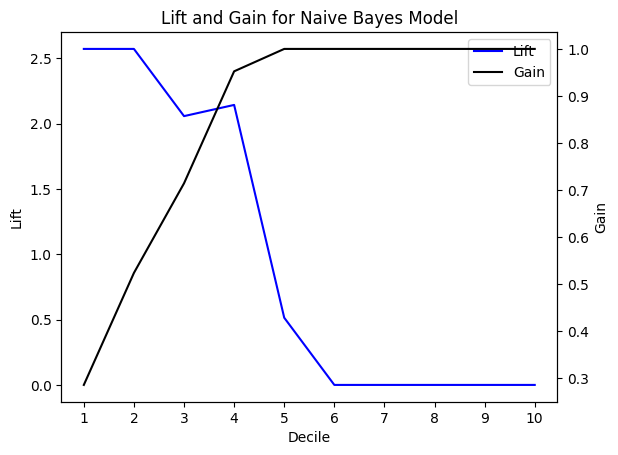

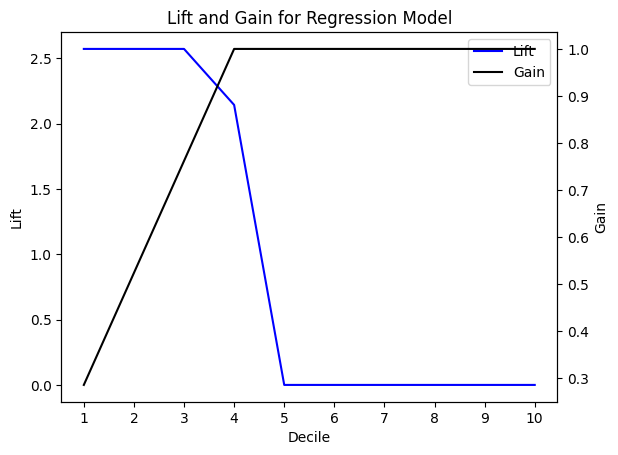

In [46]:
#Bayes
fig, ax_lift = plt.subplots()
lift_plot = ax_lift.plot(bayes_lift['decile'],bayes_lift['Lift'],'b')
ax_lift.set_xlabel("Decile")
ax_lift.set_ylabel("Lift")
ax_gain=ax_lift.twinx()
gain_plot = ax_gain.plot(bayes_gain['decile'],bayes_gain['Gain'],'k')
ax_gain.set_ylabel("Gain")

plots = lift_plot + gain_plot
labels = ['Lift', 'Gain']

ax_lift.legend(plots, labels)
plt.title("Lift and Gain for Naive Bayes Model")
plt.xticks(range(1,11))
plt.show()

#regression
fig, ax_lift = plt.subplots()
lift_plot = ax_lift.plot(regression_lift['decile'],regression_lift['Lift'],'b')
ax_lift.set_xlabel("Decile")
ax_lift.set_ylabel("Lift")
ax_gain=ax_lift.twinx()
gain_plot = ax_gain.plot(regression_gain['decile'],regression_gain['Gain'],'k')
ax_gain.set_ylabel("Gain")

plots = lift_plot + gain_plot
labels = ['Lift', 'Gain']

ax_lift.legend(plots, labels)
plt.title("Lift and Gain for Regression Model")
plt.xticks(range(1,11))
plt.show()